In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights
from utils.compressions import *

torch.set_default_dtype(torch.float64)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_pickle('data/5_moves_dataset.pkl')

In [3]:
len(df)

105045

In [4]:
def indices_to_position(indices):
    pos_array = np.array([
        [0.5, 0.5, 0], [1.5, 0.5, 0], [2.5, 0.5, 0],
        [0.5, 1.5, 0], [1.5, 1.5, 0], [2.5, 1.5, 0],
        [0.5, 2.5, 0], [1.5, 2.5, 0], [2.5, 2.5, 0],
        
        [0.5, 0.5, 3], [1.5, 0.5, 3], [2.5, 0.5, 3],
        [0.5, 1.5, 3], [1.5, 1.5, 3], [2.5, 1.5, 3],
        [0.5, 2.5, 3], [1.5, 2.5, 3], [2.5, 2.5, 3],
        
        [2.5, 0, 2.5], [2.5, 0, 1.5], [2.5, 0, 0.5],
        [1.5, 0, 2.5], [1.5, 0, 1.5], [1.5, 0, 0.5],
        [0.5, 0, 2.5], [0.5, 0, 1.5], [0.5, 0, 0.5],
        
        [0.5, 3, 2.5], [0.5, 3, 1.5], [0.5, 3, 0.5],
        [1.5, 3, 2.5], [1.5, 3, 1.5], [1.5, 3, 0.5],
        [2.5, 3, 2.5], [2.5, 3, 1.5], [2.5, 3, 0.5],
        
        [3, 2.5, 2.5], [3, 2.5, 1.5], [3, 2.5, 0.5],
        [3, 1.5, 2.5], [3, 1.5, 1.5], [3, 1.5, 0.5],
        [3, 0.5, 2.5], [3, 0.5, 1.5], [3, 0.5, 0.5],
        
        [0, 0.5, 2.5], [0, 0.5, 1.5], [0, 0.5, 0.5],
        [0, 1.5, 2.5], [0, 1.5, 1.5], [0, 1.5, 0.5],
        [0, 2.5, 2.5], [0, 2.5, 1.5], [0, 2.5, 0.5],
    ])
    return pos_array[np.array(indices)]

## 1. Volumes

In [5]:
import functools
from scipy.spatial import ConvexHull

In [6]:
@functools.lru_cache
def calc_volume(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    if (vertices[:,0] == vertices[0,0]).all() or (vertices[:,1] == vertices[0,1]).all() or (vertices[:,2] == vertices[0,2]).all():
        volume = 0
    else:
        volume = ConvexHull(vertices).volume
    return volume

In [7]:
counterVolume = 0

In [8]:
def calc_volumes(colors, verbose=True):
    if verbose:
        global counterVolume
        counterVolume += 1
        if (counterVolume + 1) % 1000 == 0:
            print(counterVolume+1)
    volumes = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        volume = calc_volume(tuple(filtered_indices))
        volumes.append(volume)
    return np.sum(volumes, dtype=np.double)[..., np.newaxis]

In [9]:
class VolumeDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_volumes).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [10]:
datasetVolume = VolumeDataset(df)
trainloaderVolume = torch.utils.data.DataLoader(datasetVolume, batch_size=32, shuffle=True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000


In [11]:
class VolumeNet(nn.Module):
    def __init__(self):
        super(VolumeNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [12]:
volumeNet = VolumeNet()

In [13]:
def compute_loss(net, dataloader):
    net.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            volumes, labels = data
            out = net(volumes)
            loss = F.mse_loss(out.squeeze(), labels)
            total_loss += loss.item()
            total += 1
    return total_loss / total

In [14]:
# Training loop
optimizerVolume = torch.optim.Adam(volumeNet.parameters(), lr=0.001)

for epoch in range(20):
    volumeNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderVolume):
        volumes, labels = data

        optimizerVolume.zero_grad()
        out = volumeNet(volumes.view(-1, 1))
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerVolume.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

Epoch 1: train loss 48.0767
Epoch 2: train loss 0.7280
Epoch 3: train loss 0.5833
Epoch 4: train loss 0.3902
Epoch 5: train loss 0.2991
Epoch 6: train loss 0.2772
Epoch 7: train loss 0.2736
Epoch 8: train loss 0.2731
Epoch 9: train loss 0.2731
Epoch 10: train loss 0.2729
Epoch 11: train loss 0.2728
Epoch 12: train loss 0.2729
Epoch 13: train loss 0.2730
Epoch 14: train loss 0.2730
Epoch 15: train loss 0.2728
Epoch 16: train loss 0.2729
Epoch 17: train loss 0.2729
Epoch 18: train loss 0.2728
Epoch 19: train loss 0.2729
Epoch 20: train loss 0.2730


### Data compressions

In [72]:
distance_all_data_volume = calculate_all_dicts_from_data(df=df, max_distance=5, input_handling_func=calc_volumes)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76032/76032 [24:59<00:00, 50.70it/s]


In [73]:
set_intersections_data_volume = compute_set_intersections(distance_all_data_volume)

Intersection size between sets 1 AND 2: 1
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 23
Intersection size between sets 2 AND 4: 26
Intersection size between sets 2 AND 5: 43
Intersection size between sets 3 AND 4: 707
Intersection size between sets 3 AND 5: 750
Intersection size between sets 4 AND 5: 1941


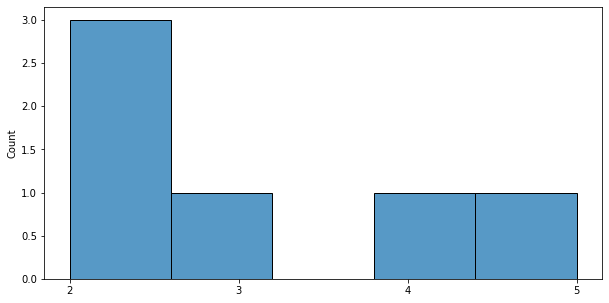

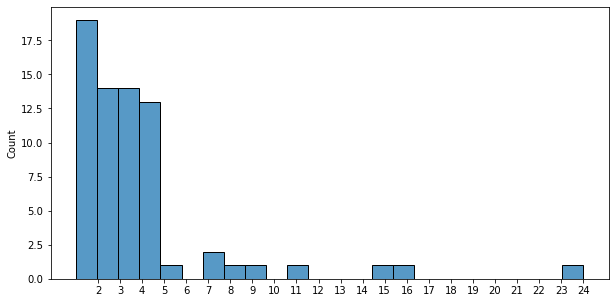

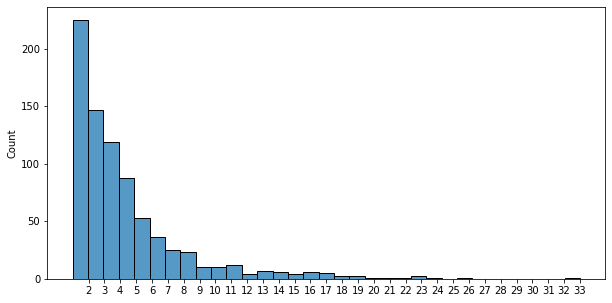

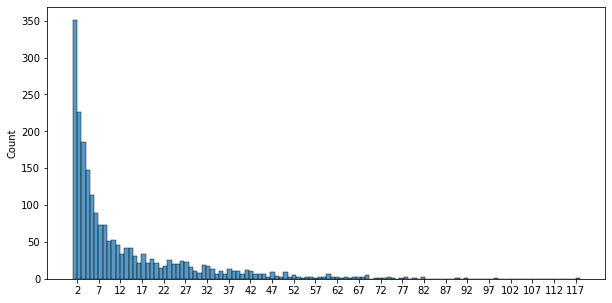

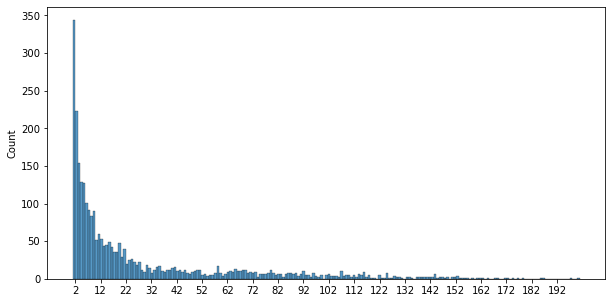

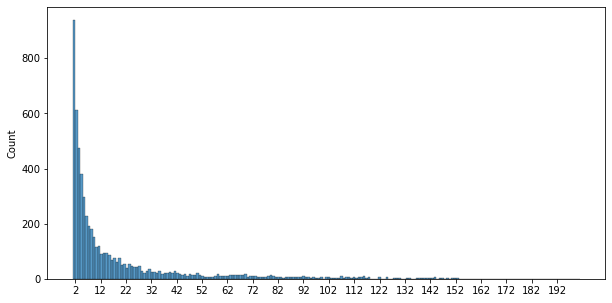

In [74]:
plot_distance_compressions(distance_all_data_volume, 'volumeNet/from_data')

### Activation compressions

In [34]:
networksVolume = create_networks(NetworkClass=VolumeNet, num_of_networks=10)
distance_all_acts_volume = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=calc_volumes, networks=networksVolume)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76032/76032 [38:16<00:00, 33.11it/s]


In [64]:
set_intersections_activations_volume = compute_set_intersections(distance_all_acts_volume)

Intersection size between sets 1 AND 2: 1
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 18
Intersection size between sets 2 AND 4: 18
Intersection size between sets 2 AND 5: 29
Intersection size between sets 3 AND 4: 310
Intersection size between sets 3 AND 5: 324
Intersection size between sets 4 AND 5: 679


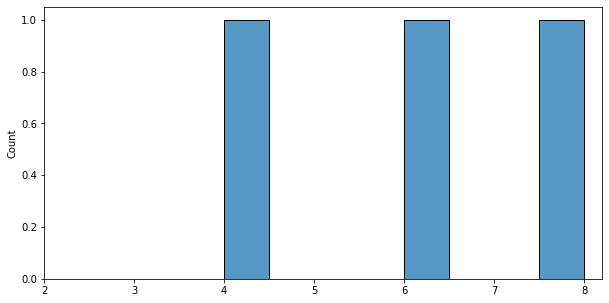

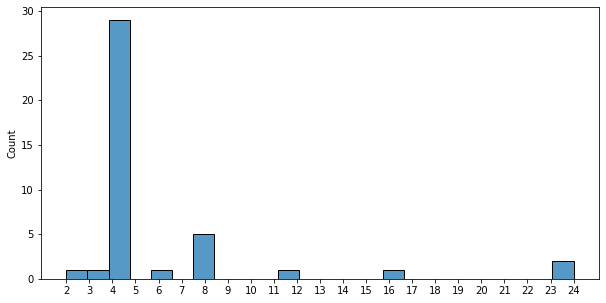

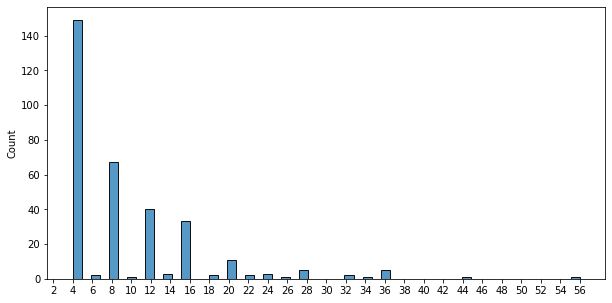

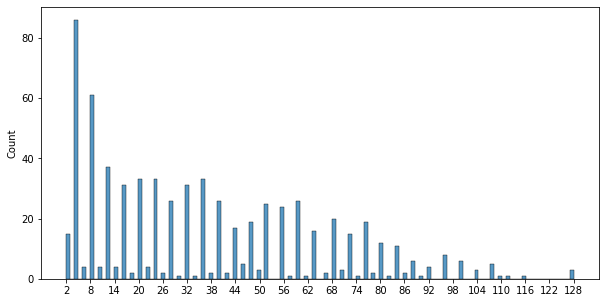

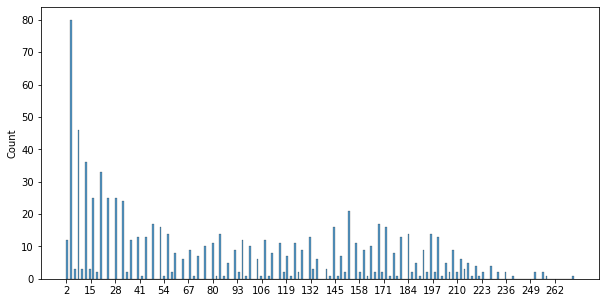

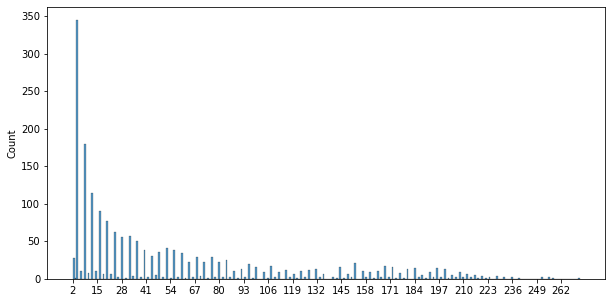

In [65]:
plot_distance_compressions(distance_all_acts_volume, 'volumeNet/from_activations')

---

## 2. Distances

In [18]:
counterDist = 0

In [19]:
def find_middle(vertices):
    for vertex in vertices:
        if vertex[0] == vertex[1] or vertex[0] == vertex[2] or vertex[1] == vertex[2]:
            return vertex
    return None

In [20]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    middle = find_middle(vertices)
    distances = np.linalg.norm(vertices - middle.reshape(1, -1), axis=1)
    distances = distances[distances != 0]
    distances = np.sort(distances)
    return distances

In [21]:
def calc_all_distances(colors, verbose=True):
    if verbose:
        global counterDist
        counterDist += 1
        if (counterDist + 1) % 1000 == 0:
            print(counterDist+1)
    distances_ls = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        distances = calc_distances(tuple(filtered_indices))
        distances_ls.append(distances)
    result = np.sum(distances_ls, axis=0, dtype=np.double)
    return result

In [22]:
class DistancesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_all_distances).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [23]:
datasetDist = DistancesDataset(df)
trainloaderDist = torch.utils.data.DataLoader(datasetDist, batch_size=32, shuffle=True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000


In [24]:
class DistNet(nn.Module):
    def __init__(self):
        super(DistNet, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [25]:
distNet = DistNet()

In [26]:
## Training loop
optimizerDist = torch.optim.Adam(distNet.parameters(), lr=0.001)

for epoch in range(20):
    distNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderDist):
        distances, labels = data

        optimizerDist.zero_grad()
        out = distNet(distances)
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerDist.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

Epoch 1: train loss 0.4989
Epoch 2: train loss 0.3208
Epoch 3: train loss 0.3113
Epoch 4: train loss 0.3032
Epoch 5: train loss 0.2969
Epoch 6: train loss 0.2919
Epoch 7: train loss 0.2895
Epoch 8: train loss 0.2871
Epoch 9: train loss 0.2859
Epoch 10: train loss 0.2848
Epoch 11: train loss 0.2847
Epoch 12: train loss 0.2840
Epoch 13: train loss 0.2837
Epoch 14: train loss 0.2839
Epoch 15: train loss 0.2834
Epoch 16: train loss 0.2835
Epoch 17: train loss 0.2834
Epoch 18: train loss 0.2833
Epoch 19: train loss 0.2833
Epoch 20: train loss 0.2833


### Data compressions

In [69]:
distance_all_data_dist = calculate_all_dicts_from_data(df=df, max_distance=5, input_handling_func=calc_all_distances)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76032/76032 [02:18<00:00, 550.53it/s]


In [70]:
set_intersections_data_dist = compute_set_intersections(distance_all_data_dist)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 2


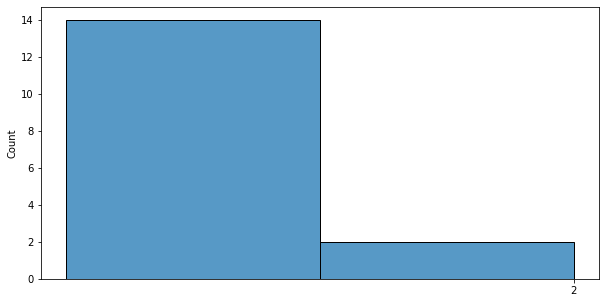

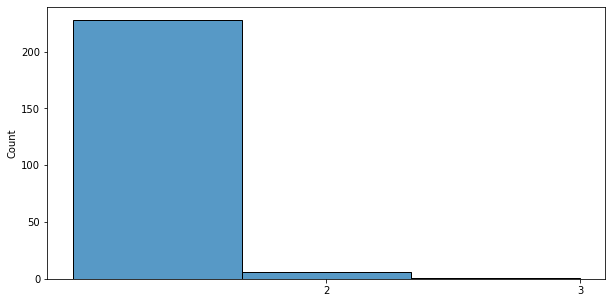

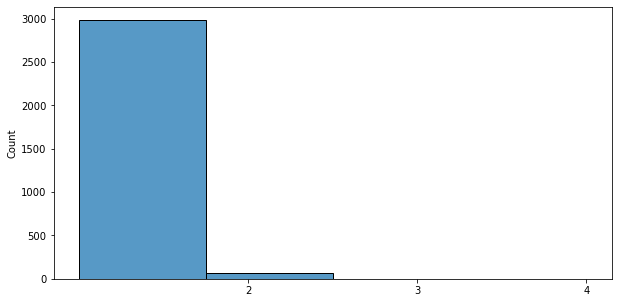

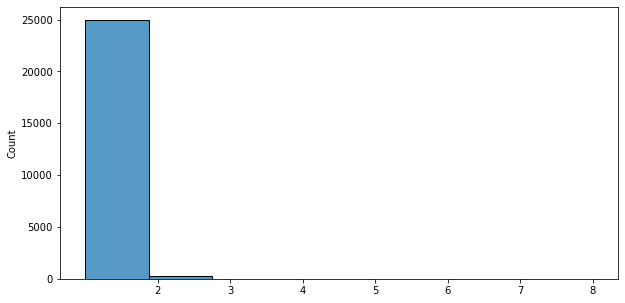

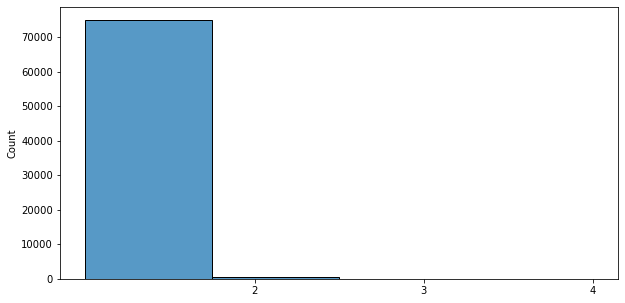

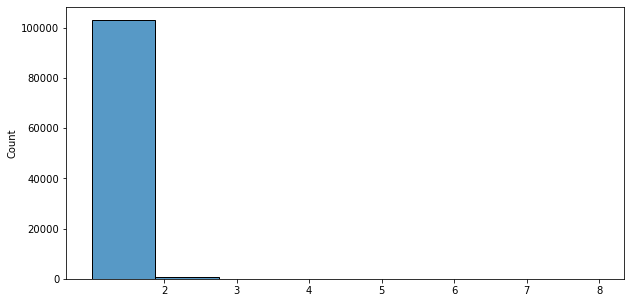

In [71]:
plot_distance_compressions(distance_all_data_dist, 'distNet/from_data')

### Activation compressions

In [42]:
networksDist = create_networks(NetworkClass=DistNet, num_of_networks=10)
distance_all_acts_dist = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=calc_all_distances, networks=networksDist)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76032/76032 [08:05<00:00, 156.58it/s]


In [62]:
set_intersections_dist = compute_set_intersections(distance_all_acts_dist)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 4


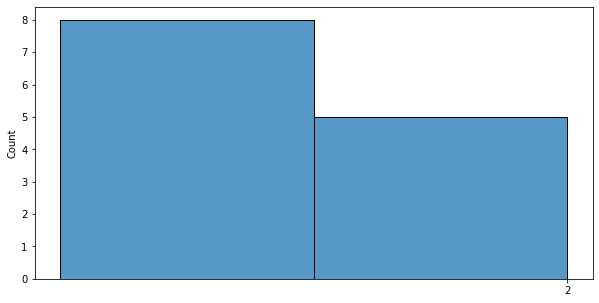

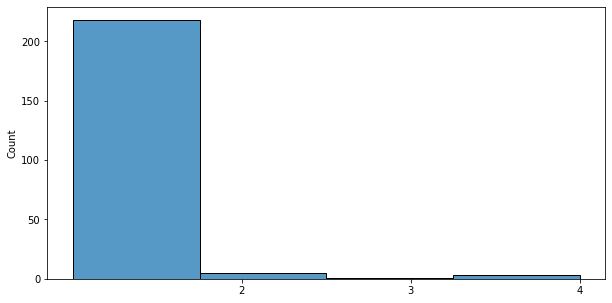

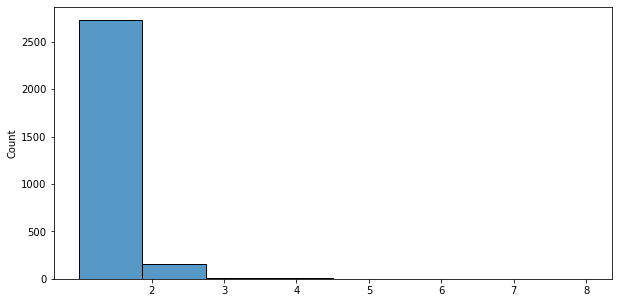

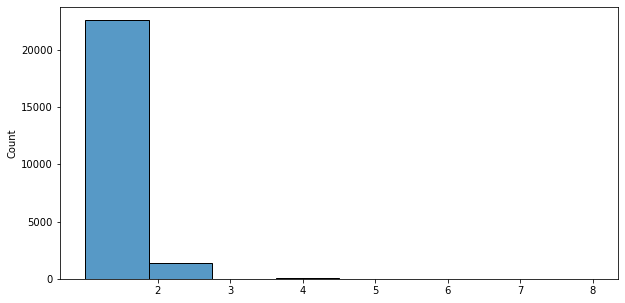

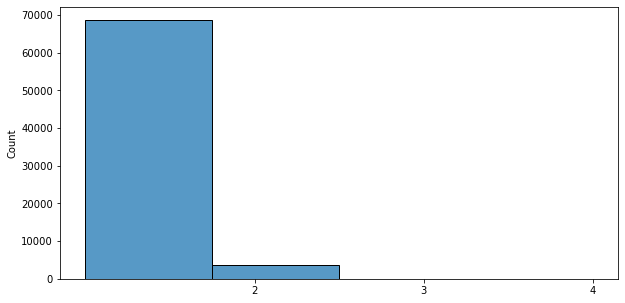

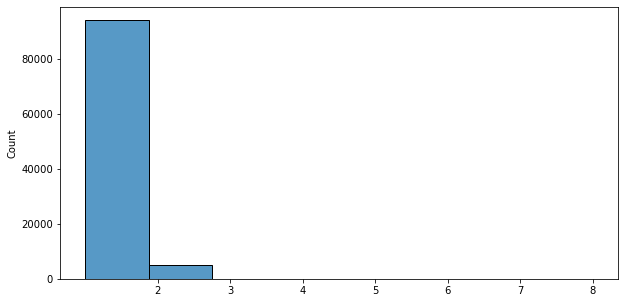

In [63]:
plot_distance_compressions(distance_all_acts_dist, 'distNet/from_activations')

---

## 3. Distances + Angles

In [45]:
counterDistAngles = 0

In [46]:
def unit_vector(vector):
    """ Returns the unit vector of the vector. """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [47]:
@functools.lru_cache
def calc_distances_angles(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    middle = find_middle(vertices)
    distances = np.linalg.norm(vertices - middle.reshape(1, -1), axis=1)
    angles = angle_between(vertices[distances != 0], middle)
    distances = distances[distances != 0]
    sorted_indices = np.argsort(distances)
    distances = distances[sorted_indices]
    angles = angles[sorted_indices]
    return np.concatenate((distances, angles), axis=0)

In [48]:
def calc_all_distances_angles(colors, verbose=True):
    if verbose:
        global counterDistAngles
        counterDistAngles += 1
        if (counterDistAngles + 1) % 10000 == 0:
            print(counterDistAngles+1)
    distances_angles_ls = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        distances_angles = calc_distances_angles(tuple(filtered_indices))
        distances_angles_ls.append(distances_angles)
    result = np.sum(distances_angles_ls, axis=0, dtype=np.double)
    return result

In [49]:
class DistancesAnglesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_all_distances_angles).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [50]:
datasetDistAngles = DistancesAnglesDataset(df)
trainloaderDistAngles = torch.utils.data.DataLoader(datasetDistAngles, batch_size=32, shuffle=True)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [51]:
class DistAnglesNet(nn.Module):
    def __init__(self):
        super(DistAnglesNet, self).__init__()
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [52]:
distAnglesNet = DistAnglesNet()

In [53]:
## Training loop
optimizerDistAngles = torch.optim.Adam(distAnglesNet.parameters(), lr=0.001)

for epoch in range(50):
    distAnglesNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderDistAngles):
        distances_angles, labels = data

        optimizerDistAngles.zero_grad()
        out = distAnglesNet(distances_angles)
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerDistAngles.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

Epoch 1: train loss 0.5115
Epoch 2: train loss 0.2935
Epoch 3: train loss 0.2907
Epoch 4: train loss 0.2902
Epoch 5: train loss 0.2885
Epoch 6: train loss 0.2889
Epoch 7: train loss 0.2878
Epoch 8: train loss 0.2875
Epoch 9: train loss 0.2874
Epoch 10: train loss 0.2873
Epoch 11: train loss 0.2867
Epoch 12: train loss 0.2864
Epoch 13: train loss 0.2864
Epoch 14: train loss 0.2863
Epoch 15: train loss 0.2862
Epoch 16: train loss 0.2857
Epoch 17: train loss 0.2855
Epoch 18: train loss 0.2854
Epoch 19: train loss 0.2853
Epoch 20: train loss 0.2852
Epoch 21: train loss 0.2851
Epoch 22: train loss 0.2852
Epoch 23: train loss 0.2851
Epoch 24: train loss 0.2851
Epoch 25: train loss 0.2846
Epoch 26: train loss 0.2846
Epoch 27: train loss 0.2842
Epoch 28: train loss 0.2844
Epoch 29: train loss 0.2847
Epoch 30: train loss 0.2841
Epoch 31: train loss 0.2842
Epoch 32: train loss 0.2842
Epoch 33: train loss 0.2840
Epoch 34: train loss 0.2841
Epoch 35: train loss 0.2843
Epoch 36: train loss 0.2839
E

### Data compressions

In [66]:
distance_all_data_dist_angle = calculate_all_dicts_from_data(df=df, max_distance=5, input_handling_func=calc_all_distances_angles)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76032/76032 [03:28<00:00, 365.39it/s]


In [67]:
set_intersections_data_dist_angle = compute_set_intersections(distance_all_data_dist_angle)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


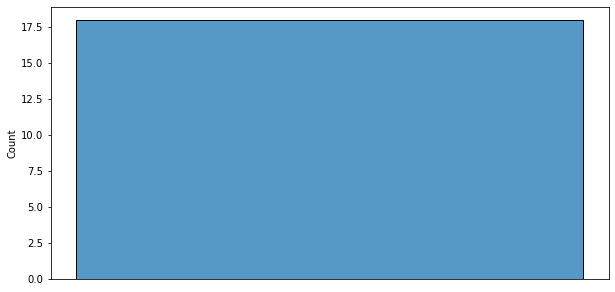

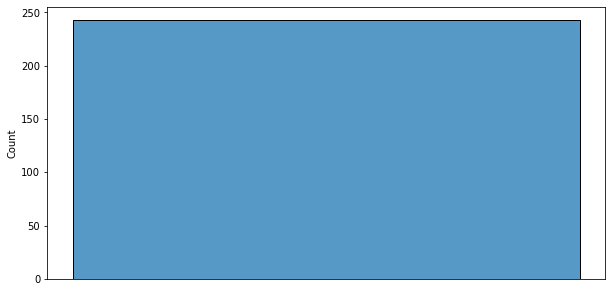

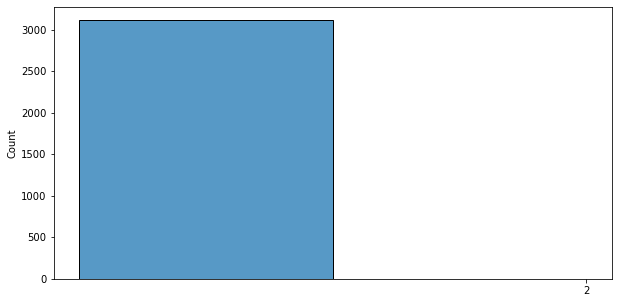

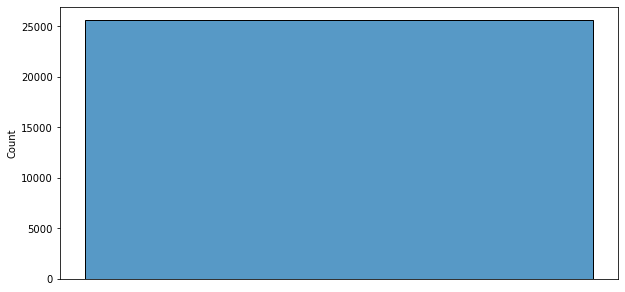

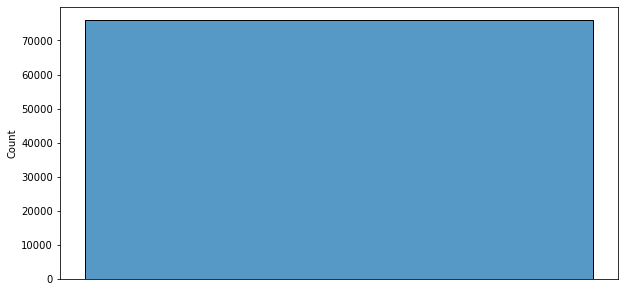

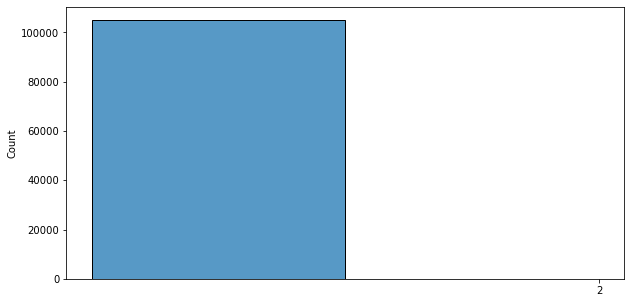

In [68]:
plot_distance_compressions(distance_all_data_dist_angle, 'distAngleNet/from_data')

### Activation compressions

In [57]:
networksDistAngle = create_networks(NetworkClass=DistAnglesNet, num_of_networks=10)
distance_all_acts_dist_angle = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=calc_all_distances_angles, networks=networksDistAngle)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76032/76032 [09:19<00:00, 135.81it/s]


In [60]:
set_intersections_activations_dist_angle = compute_set_intersections(distance_all_acts_dist_angle)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


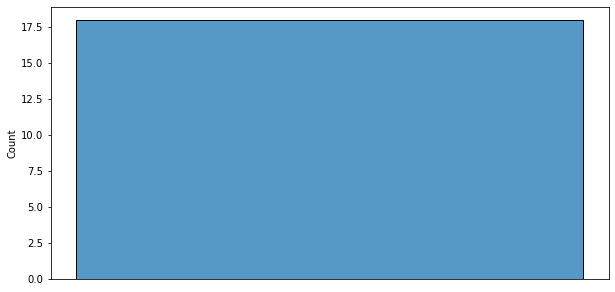

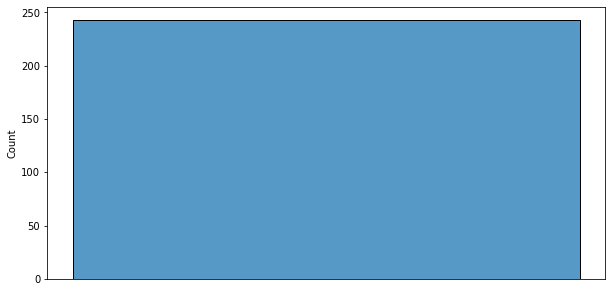

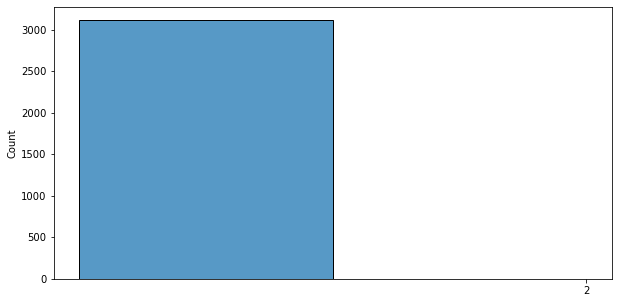

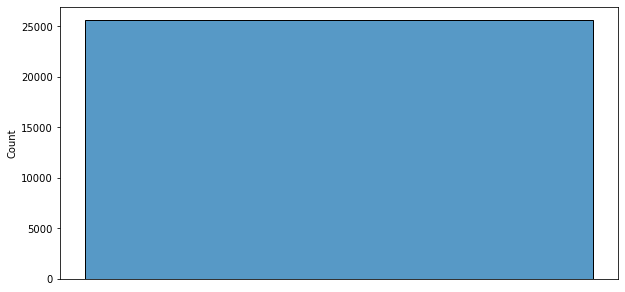

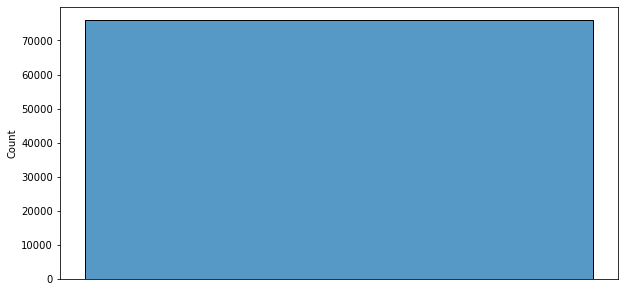

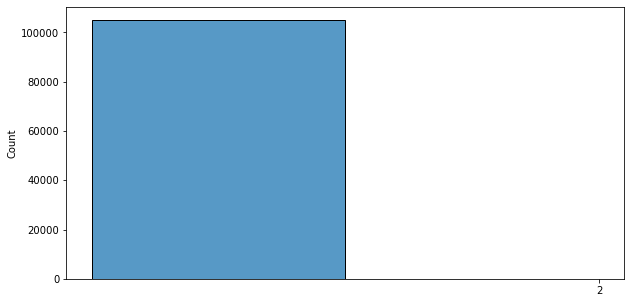

In [61]:
plot_distance_compressions(distance_all_acts_dist_angle, 'distAngleNet/from_activations')